In [1]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import time
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
plt.style.use("ggplot")
mpl.pyplot.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams["font.size"] = 13
#mpl.rcParams["font.family"] = 'Osaka'

import sys
sys.path.append('../code/')

from simulation_tx_fee import *
from simulation_fixed_path import make_stats, stats_tx
from hash import *
from plot_path import *

## Reduced form analysis for transaction fee

* See the Appendix in `simulation.ipynb` for the construction of `BTCdata_2018OctDec.csv`.

In [2]:
path = '../data/BTCdata_2.csv'
df_full = pd.read_csv(path, header=0)

# during the period, the block reward was 12.5 BTC
df_full['tx_fee'] = df_full['reward_BTC'] - 12.5
df_full['tx_fee_USD'] = df_full['tx_fee']*df_full['Close']
df_tx = df_full[['height', 'tx_fee', 'tx_fee_USD']]

path = '../data/BTCdata_2018OctDec.csv'
df = pd.read_csv(path, header=0)

df = pd.merge(df, df_tx, on='height')

In [3]:
# price data were collected every one hour?
df['price'].unique().shape[0]

2117

**Problem: price data was collected every one hour**
* Price difference is used to measure the speed of price change
  - Logic: the faster the price changes, the more transaction investors wants to make, which may increases the transaction fee.
* Below, I assume that price difference (= the speed of price change) is constant in each time window (one hour)   

In [4]:
price_diff = df['price'].diff().values
temp = 0
for i in range(price_diff.shape[0]):
    if not np.isclose(price_diff[i], 0):
        price_diff[temp:i] = price_diff[i]
        temp = i+1
df['price_diff'] = np.abs(price_diff)

window = 10
df['ave_blocktime'] = df["adjusted_blocktime"].rolling(window).mean()

df.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,adjusted_time,tx_fee,tx_fee_USD,price_diff,ave_blocktime
0,543835,1538352272,6621.3,0.000033,2.720620,2018-10-01 00:04:32,1538352272,18.633333,2018-10-01 00:04:32,0.122639,812.029743,NaN,NaN
1,543836,1538352799,6621.3,0.000033,2.711797,2018-10-01 00:13:19,1538352799,8.783333,2018-10-01 00:13:19,0.081705,540.990006,11.31,NaN
2,543837,1538352841,6621.3,0.000033,2.694189,2018-10-01 00:14:01,1538352841,0.700000,2018-10-01 00:14:01,0.000014,0.090579,11.31,NaN
3,543838,1538352940,6621.3,0.000033,2.697526,2018-10-01 00:15:40,1538352940,1.650000,2018-10-01 00:15:40,0.015493,102.584595,11.31,NaN
4,543839,1538353463,6621.3,0.000033,2.714195,2018-10-01 00:24:23,1538353463,8.716667,2018-10-01 00:24:23,0.092831,614.664218,11.31,NaN


* Run a regression:
$$
\log \text{Tx fee}_t = \beta_0 + \beta_1 \log \text{Ave. blocktime}_t + \beta_2 \log \text{price}_t + \beta_3 \log \text{price diff}_t + \epsilon_t,
$$
where $\text{price diff}_t := \text{price}_t - \text{price}_{t-1}$.

* Ave. blocktime is computed using 10 recent blocks.

In [5]:
df.shape

(12624, 13)

In [6]:
df = df[df['price_diff']!=0]
df = df[df['tx_fee']!=0]
df = df[df['tx_fee_USD']<10000]
df.shape

(12520, 13)

In [7]:
df_reg = df.dropna()
X = df_reg[['ave_blocktime', 'price', 'price_diff']]
Y = df_reg['tx_fee_USD']

In [8]:
results = smf.ols('np.log(tx_fee_USD) ~ np.log(ave_blocktime) + np.log(price) + np.log(price_diff)', data=df_reg).fit()

In [9]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(tx_fee_USD)   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     973.2
Date:                Mon, 06 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:56:26   Log-Likelihood:                -18141.
No. Observations:               12511   AIC:                         3.629e+04
Df Residuals:                   12507   BIC:                         3.632e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.7377      0.323     -8.464      0.000      -3.372      -2.104
np.log(ave_blocktime)     1.3849      0.028     49.474      0.000       1.330       1.440
np.log(price)             0.6563      0.037     17.931      0.000       0.585       0.728
np.log(price_diff)        0.1056      0.007     15.768      0.000       0.092       0.119
==============================================================================
Omnibus:                     3955.346   Durbin-Watson:                   1.471
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19053.590
Skew:                          -1.460   Prob(JB):                         0.00
Kurtosis:                       8.294   Cond. No.                         323.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Simple linear regression yields R-square 0.189.
* Can we make it higher by adding higher-degree polynomials?

In [38]:
df_poly = df_reg.copy()
deg_poly = 3

reg_var_list = []
cov_list = ['ave_blocktime', 'price', 'price_diff']
for var_name in cov_list:
    for i in range(1,deg_poly+1):
        col_name = 'log_' + var_name + '_{}'.format(i)
        val = np.log(df_poly[var_name])**i
        df_poly[col_name] = val
        reg_var_list.append(col_name)
df_poly['log_tx_fee'] = np.log(df_poly['tx_fee_USD'])

In [39]:
X_poly = df_poly[reg_var_list]
X_poly = sm.add_constant(X_poly)
Y_poly = df_poly['log_tx_fee']

model_poly = sm.OLS(Y_poly, X_poly)
res_poly = model_poly.fit()
res_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_tx_fee   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     368.1
Date:                Mon, 06 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:02:41   Log-Likelihood:                -17983.
No. Observations:               12511   AIC:                         3.599e+04
Df Residuals:                   12501   BIC:                         3.606e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3939.6505    839.532      4.693      0.000    2294.040    5585.261
log_ave_blocktime_1    -2.7877      1.334     -2.090      0.037      -5.402      -0.173
log_ave_blocktime_2     1.9753      0.615      3.212      0.001       0.770       3.181
log_ave_blocktime_3    -0.3051      0.093     -3.273      0.001      -0.488      -0.122
log_price_1         -1440.0836    299.352     -4.811      0.000   -2026.860    -853.307
log_price_2           175.3985     35.566      4.932      0.000     105.683     245.114
log_price_3            -7.1082      1.408     -5.048      0.000      -9.868      -4.348
log_price_diff_1        0.0388      0.012      3.342      0.001       0.016       0.061
log_price_diff_2        0.0074      0.003      2.469      0.014       0.002       0.013
log_price_diff_3        0.0012      0.001      1.542      0.123      -0.000       0.003
==============================================================================
Omnibus:                     4064.664   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19839.860
Skew:                          -1.500   Prob(JB):                         0.00
Kurtosis:                       8.391   Cond. No.                     6.14e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.14e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

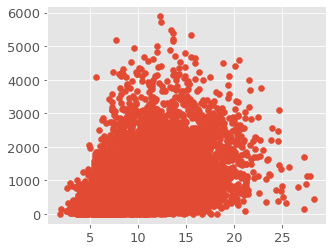

In [16]:
plt.scatter(df_reg['ave_blocktime'], Y)
plt.show()

$$
\log \text{Tx fee}_t = \beta_0 + \beta_1 \log \text{Ave. blocktime}_t + \beta_2 \log \text{price}_t + \beta_3 \log \text{price diff}_t + \epsilon_t,
$$

$$
\hat \beta_0 = -2.74, \hat \beta_1 = 1.385, \hat \beta_2 = 0.656, \hat \beta_3 = 0.106.
$$

## Simulation

* In each period $t$, hash supply $H_t$ is computed given the transaction fee $T_t$.
  - the expected reward is changed to be $(S_t M_t + T_t)W_t$.
  - in the baseline model, it was $S_t M_t W_t$.

In [10]:
path = '../data/BTCdata_presim.csv'
df = pd.read_csv(path)
df['time'] = pd.to_datetime(df['time'])
df = df.rename(columns={'blocktime': 'block_times', 'price': 'prices', 'probability of success /Eh': 'winning_rates'})

In [ ]:
generate_simulation_data(num_iter=5000, prev_data=df)
print('DAA-1 and DAA-2 are done.')

In [12]:
generate_simulation_data_asert(num_iter=5000, prev_data=df)
print('ASERT is done.')

ASERT is done.


In [13]:
dir_sim = '/Volumes/Data/research/BDA/simulation/'
filelist = [dir_sim+'tx_DAA-1_blocktime_ps0_5000obs_T=None.csv',
            dir_sim+'tx_DAA-2_blocktime_ps0_5000obs_T=None.csv',
            dir_sim+'tx_DAA_asert_blocktime_ps0_5000obs_T=None.csv',
            ]
df_stats_ = make_stats(filelist=filelist, dir_sim=dir_sim)

In [14]:
# DAA-1 gets slightly better, but almost the same as before
# the winning rate is determined before the tx fee in the same period is calculated; DAA-0 is not exactly the optimal anymore
df_stats_

,tx_DAA-1_blocktime_ps0_5000obs_T=None.csv,tx_DAA-2_blocktime_ps0_5000obs_T=None.csv,tx_DAA_asert_blocktime_ps0_5000obs_T=None.csv
mean,12.109877,10.034051,10.053141
std,15.458327,10.218585,10.120250
over60,1.000000,1.000000,1.000000
over120,0.807400,0.176600,0.112800
over180,0.446600,0.001600,0.000400


In [17]:
dir_sim = '/Volumes/Data/research/BDA/simulation/'
filelist = [dir_sim+'tx_DAA-1_tx_fee_ps0_5000obs_T=None.csv',
            dir_sim+'tx_DAA-2_tx_fee_ps0_5000obs_T=None.csv',
            dir_sim+'tx_DAA_asert_tx_fee_ps0_5000obs_T=None.csv']
df_stats = stats_tx(filelist, dir_sim)

In [18]:
# tx_fee
df_stats

,tx_DAA-1_tx_fee_ps0_5000obs_T=None.csv,tx_DAA-2_tx_fee_ps0_5000obs_T=None.csv,tx_DAA_asert_tx_fee_ps0_5000obs_T=None.csv
mean,567.211748,409.869201,410.111457
std,575.427539,265.652641,261.127387
over3000,0.949600,0.212400,0.176600
over3500,0.822200,0.080800,0.061600
over4000,0.675400,0.029000,0.019400
over4500,0.565400,0.010400,0.007800
over5000,0.479200,0.004200,0.003000
over5500,0.405800,0.001600,0.001800
over6000,0.352800,0.000800,0.000600
